In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# seleziono solo le righe contenenti i paesi europei
def eu_state(df, eu_countries):
  df_eu = df[df['Country'].isin(eu_countries)]
  return df_eu


eu_countries = [
    "Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czech Republic", "Denmark", "Estonia", "Finland",
    "France", "Germany", "Greece", "Hungary", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta",
    "Netherlands", "Poland", "Portugal", "Romania", "Slovakia", "Slovenia", "Spain", "Sweden"
]


CO2df = pd.read_csv('/content/CO2_Emissions.csv')
Renewable_Electricity = pd.read_csv('/content/Renewable_Electricity_Production_Dataset.csv')

# rinomino la colonna : "Country and area" in "Country"
Renewable_Electricity = Renewable_Electricity.rename(columns={"Country and area": "Country"})

CO2df_eu = eu_state(CO2df, eu_countries)
Renewable_Electricity_eu = eu_state(Renewable_Electricity, eu_countries)

# Seleziona solo le colonne con anno > 2005 (escludendo 'Country')
Renewable_Electricity_eu = Renewable_Electricity_eu.loc[:, ['Country'] + [
    col for col in Renewable_Electricity_eu.columns if col != 'Country' and int(col) >= 2005
]]

Renewable_Electricity_eu.head()

,Country,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
11,Austria,61.04,61.91,63.42,63.91,66.13,61.48,60.63,69.57,72.57,75.61,71.04,72.15,70.77,69.88,70.26,69.95,69.61,70.60,70.48
18,Belgium,2.41,2.63,2.73,3.16,3.29,3.97,5.58,8.18,10.10,12.88,15.03,12.27,14.13,13.43,13.43,14.84,13.26,13.81,13.11
29,Bulgaria,10.67,10.03,7.58,7.55,10.03,13.72,9.21,12.73,17.23,16.34,18.29,16.37,14.04,13.71,14.34,13.64,14.56,13.17,14.53
48,Croatia,54.33,51.81,38.55,46.01,56.10,62.88,47.16,49.56,65.86,72.97,64.97,63.48,56.54,56.86,57.86,56.41,57.11,58.18,57.59
51,Cyprus,0.02,0.02,0.04,0.06,0.08,0.71,2.56,4.39,6.48,6.11,7.65,7.61,8.09,6.85,8.27,7.69,7.68,7.48,7.67


In [8]:

# Estraggo gli anni dalle colonne (escludendo la prima colonna, 'Country')
years = np.array([int(year) for year in CO2df_eu.columns[1:]], dtype=int).reshape(-1, 1)

# Definisco gli anni futuri per la previsione (dal 2024 al 2035 incluso)
future_years = np.arange(2024, 2036).reshape(-1, 1)


In [9]:
def linear_regression(df, years, future_years):
    # Inizializza struttura per le predizioni future (dal 2024 al 2035 incluso)
    predictions = pd.DataFrame({'Year': np.arange(2024, 2036)})

    # Inizializza DataFrame per memorizzare le metriche dei modelli
    metrics_df = pd.DataFrame(columns=['Country', 'RMSE', 'R2'])

    # Ciclo su ogni paese per creare un modello individuale
    for country in df['Country']:
        # Estrai i dati storici di emissioni per il paese
        country_data = df[df['Country'] == country].iloc[:, 1:].values.flatten()

        # Definisci e addestra il modello di regressione lineare
        model = LinearRegression()
        model.fit(years, country_data)

        # Predizione sui dati storici (in-sample)
        y_pred = model.predict(years)

        # Calcolo delle metriche di errore
        rmse = np.sqrt(mean_squared_error(country_data, y_pred))
        r2 = r2_score(country_data, y_pred)

        # Salvataggio delle metriche nel DataFrame
        metrics_df.loc[len(metrics_df)] = {
            'Country': country,
            'RMSE': rmse,
            'R2': r2
        }

        # Predizione dei valori futuri (2024–2035)
        future_predictions = model.predict(future_years)

        # Inserisci le predizioni nel DataFrame finale
        predictions[country] = future_predictions

    return predictions, metrics_df


regression_predictions, metrics_df_regression = linear_regression(CO2df_eu, years=years, future_years=future_years)
regression_predictions.head()


,Year,Austria,Belgium,Bulgaria,Croatia,Cyprus,Denmark,Estonia,Finland,France,...,Luxembourg,Malta,Netherlands,Poland,Portugal,Romania,Slovakia,Slovenia,Spain,Sweden
0,2024,58073.610214,80677.728021,38032.213690,16324.935080,8235.883636,33656.07369,11976.538877,43394.207433,285480.794706,...,8735.058449,4810.112353,149809.175615,261049.378503,47436.513636,51086.948717,31031.595722,12354.555134,251731.202193,37642.229679
1,2025,57679.949436,78978.108060,37365.127195,16182.867656,8300.653054,32636.87259,11641.145720,42732.306850,280433.310924,...,8661.282024,4903.811748,148865.860390,257604.552972,47067.028953,48516.564089,30477.518671,12221.341830,250343.958486,36901.338031
2,2026,57286.288659,77278.488098,36698.040700,16040.800232,8365.422472,31617.67149,11305.752564,42070.406266,275385.827143,...,8587.505600,4997.511143,147922.545164,254159.727441,46697.544270,45946.179461,29923.441620,12088.128527,248956.714779,36160.446382
3,2027,56892.627881,75578.868136,36030.954205,15898.732808,8430.191890,30598.47039,10970.359407,41408.505682,270338.343361,...,8513.729175,5091.210538,146979.229939,250714.901910,46328.059587,43375.794833,29369.364568,11954.915224,247569.471073,35419.554733
4,2028,56498.967103,73879.248174,35363.867710,15756.665384,8494.961308,29579.26929,10634.966251,40746.605099,265290.859580,...,8439.952750,5184.909933,146035.914714,247270.076379,45958.574905,40805.410205,28815.287517,11821.701921,246182.227366,34678.663085


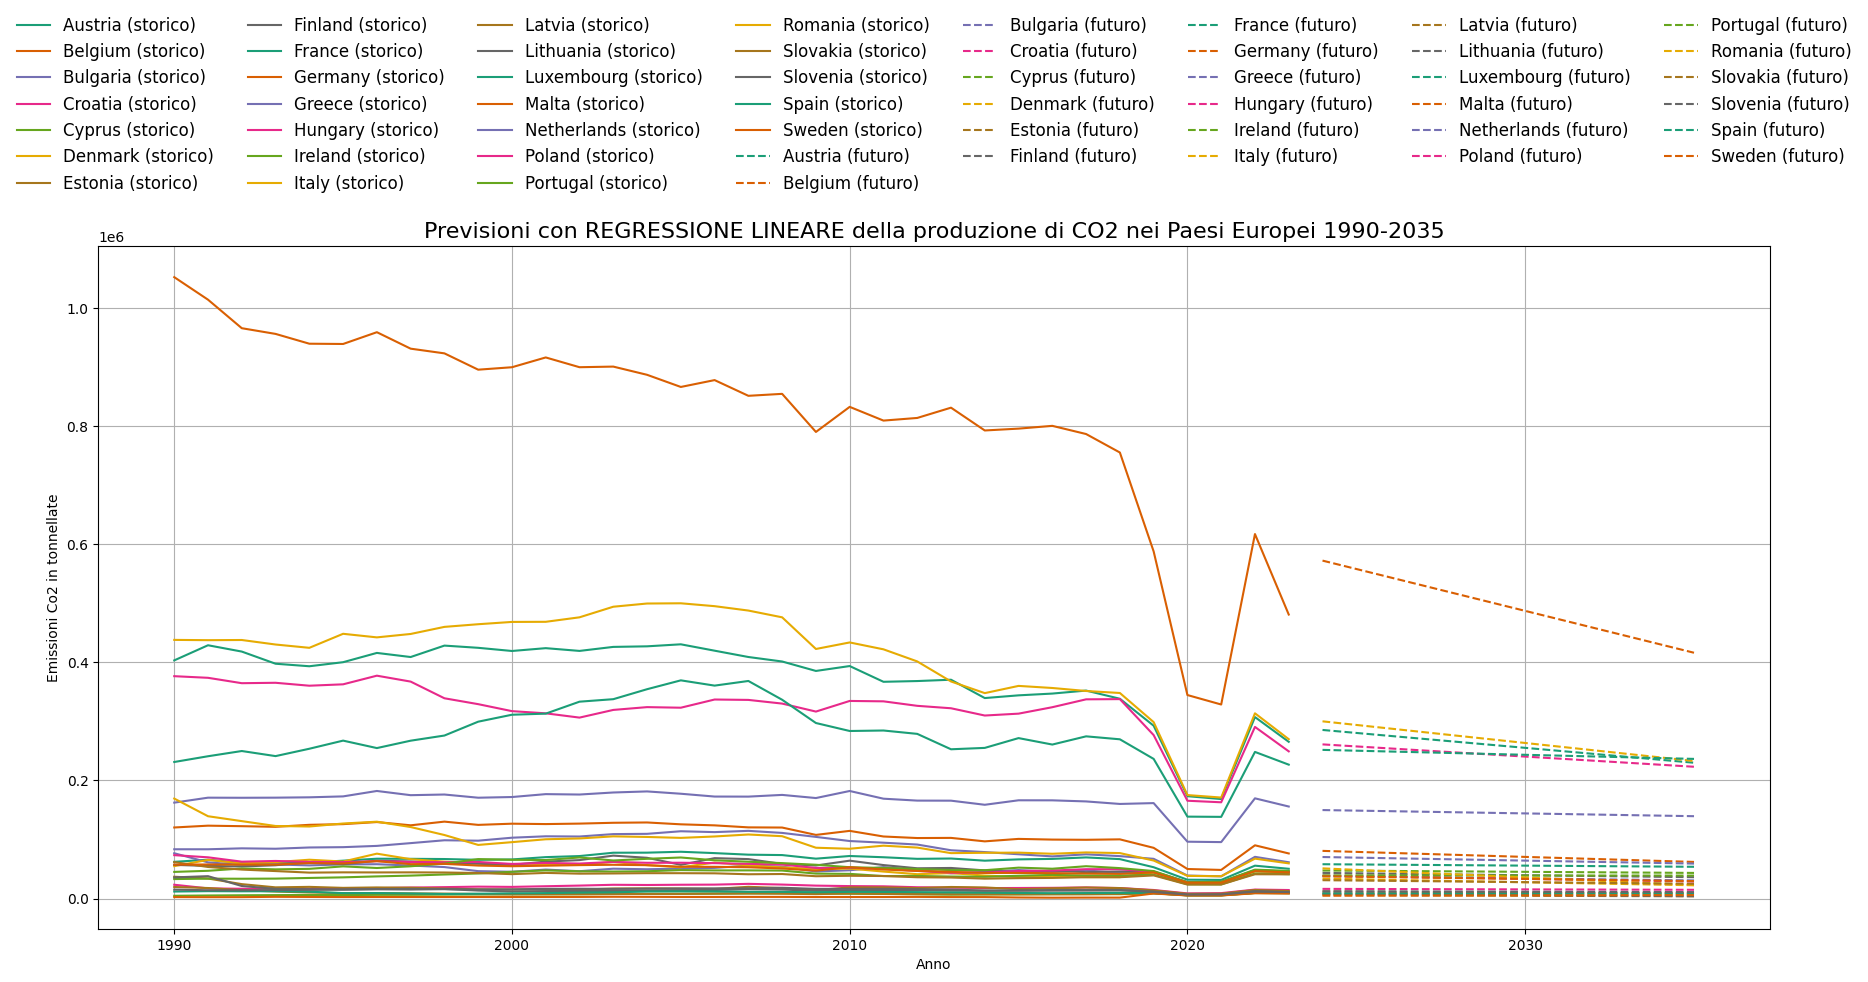

In [42]:
def plot_trend(df, predictions, string, stringtype, stringyears, ylabe):
    """
    Visualizza i trend del df e le relative predizioni.
    """

    # Crea la figura con due aree: una per la legenda sopra, una per il grafico sotto
    fig = plt.figure(figsize=(20, 10))
    grid = fig.add_gridspec(nrows=2, height_ratios=[0.15, 0.85])  # 15% per legenda

    ax_legend = fig.add_subplot(grid[0])
    ax_main = fig.add_subplot(grid[1])

    # Palette colori
    countries = df['Country'].unique()
    color_palette = plt.cm.Dark2.colors
    extended_palette = color_palette * ((len(countries) // len(color_palette)) + 1)
    color_map = {country: extended_palette[i] for i, country in enumerate(countries)}

    historical_years = df.columns[1:].astype(int)
    future_years = predictions['Year']

    handles = []  # per la legenda
    labels = []

    # Plot storico
    for country in countries:
        values = df[df['Country'] == country].iloc[:, 1:].values.flatten()
        line, = ax_main.plot(historical_years, values, label=f'{country} (storico)', color=color_map[country])
        handles.append(line)
        labels.append(f'{country} (storico)')

    # Plot predizioni
    for country in predictions.columns[1:]:
        if country in color_map:
            line, = ax_main.plot(future_years, predictions[country], '--', label=f'{country} (futuro)', color=color_map[country])
            handles.append(line)
            labels.append(f'{country} (futuro)')

    # Legenda in asse separato sopra
    ax_legend.axis('off')
    ax_legend.legend(
        handles=handles,
        labels=labels,
        loc='center',
        ncol=8,  # puoi aumentare/diminuire in base alla larghezza
        fontsize=12,
        frameon=False
    )

    # Titolo e assi
    ax_main.set_title(f'Previsioni con {string} della produzione di {stringtype} nei Paesi Europei {stringyears}', fontsize=16)
    ax_main.set_xlabel('Anno')
    ax_main.set_ylabel(f'{ylabe}')
    ax_main.grid(True)

    plt.tight_layout()
    plt.show()

plot_trend(CO2df_eu, regression_predictions, "REGRESSIONE LINEARE", "CO2", "1990-2035", "Emissioni Co2 in tonnellate")

In [11]:
# metriche algoritmo predittivo con regressione lineare
metrics_df_regression.head()

,Country,RMSE,R2
0,Austria,9794.724758,0.134555
1,Belgium,12352.978660,0.645648
2,Bulgaria,5758.002782,0.563676
3,Croatia,3443.809527,0.140745
4,Cyprus,997.912061,0.288493


In [12]:
from sklearn.preprocessing import PolynomialFeatures

# Inizializzo la struttura per le predizioni future (dal 2024 al 2035 incluso)
predictions_poly = pd.DataFrame({'Year': np.arange(2024, 2036)})

# Sceglo il grado del polinomio
degree = 2



In [13]:
def regression_polinomial(df, degree, years, future_years):
    # Inizializza DataFrame per memorizzare le metriche dei modelli
    metrics_poly_df = pd.DataFrame(columns=['Country', 'RMSE', 'R2'])

    # Ciclo su ogni paese per creare un modello individuale
    for country in df['Country']:
        # Estrai i dati storici di emissioni per il paese
        country_data = df[df['Country'] == country].iloc[:, 1:].values.flatten()

        # trasformo gli anni in formato polinomiale
        poly = PolynomialFeatures(degree=degree)
        years_poly = poly.fit_transform(years)

        # Definisco e addestro il modello di regressione lineare
        model = LinearRegression()
        model.fit(years_poly, country_data)

        # Predizione sui dati storici (in-sample)
        y_pred = model.predict(years_poly)

        # Calcolo delle metriche di errore
        rmse = np.sqrt(mean_squared_error(country_data, y_pred))
        r2 = r2_score(country_data, y_pred)

        # Salvataggio delle metriche nel DataFrame
        metrics_poly_df.loc[len(metrics_poly_df)] = {
            'Country': country,
            'RMSE': rmse,
            'R2': r2
        }

        # Predizione dei valori futuri (2024–2035)
        future_years_poly = poly.transform(future_years.reshape(-1, 1))
        future_predictions = model.predict(future_years_poly)

        # imposto i numeri negativi a 0
        future_predictions = np.maximum(future_predictions, 0)

        # Inserisci le predizioni nel DataFrame finale
        predictions_poly[country] = future_predictions
    return predictions_poly, metrics_poly_df

co2_predictions_poly, metrics_poly_df = regression_polinomial(CO2df_eu, degree, years=years, future_years=future_years)

co2_predictions_poly.head()

,Year,Austria,Belgium,Bulgaria,Croatia,Cyprus,Denmark,Estonia,Finland,France,...,Luxembourg,Malta,Netherlands,Poland,Portugal,Romania,Slovakia,Slovenia,Spain,Sweden
0,2024,40015.395275,59335.279193,40036.713240,10185.009263,6982.888783,30243.093241,15287.547434,30566.747089,210360.111983,...,8090.713145,7005.167466,130004.670299,240673.397804,31095.853611,53564.535718,34404.711214,8057.132524,153068.132720,33670.286397
1,2025,36526.040508,53976.953718,39713.255239,8990.383128,6832.859083,28638.809778,15519.755744,27705.853303,192434.796876,...,7906.477525,7475.162024,125666.297019,233735.547011,27925.112924,51418.880290,34428.882533,7187.218201,134767.219962,32248.490186
2,2026,32864.702741,48415.366825,39408.887710,7737.281508,6670.896099,27002.021740,15783.497469,24722.793229,173794.046697,...,7716.105284,7966.061868,121139.309404,226603.639259,24598.746903,49296.820929,34485.178761,6276.376045,115526.658924,30788.865943
3,2027,29031.381975,42650.518515,39123.610653,6425.704405,6496.999831,25332.729126,16078.772609,21617.566865,154437.861443,...,7519.596420,8477.866999,116423.707452,219277.674548,21116.755549,47198.357635,34573.599899,5324.606054,95346.449605,29291.413669
4,2028,25026.078210,36682.408787,38857.424068,5055.651817,6311.170278,23630.931936,16405.581164,18390.174213,134366.241116,...,7316.950934,9010.577416,111519.491164,211757.652877,17479.138861,45123.490407,34694.145946,4331.908229,74226.592006,27756.133364


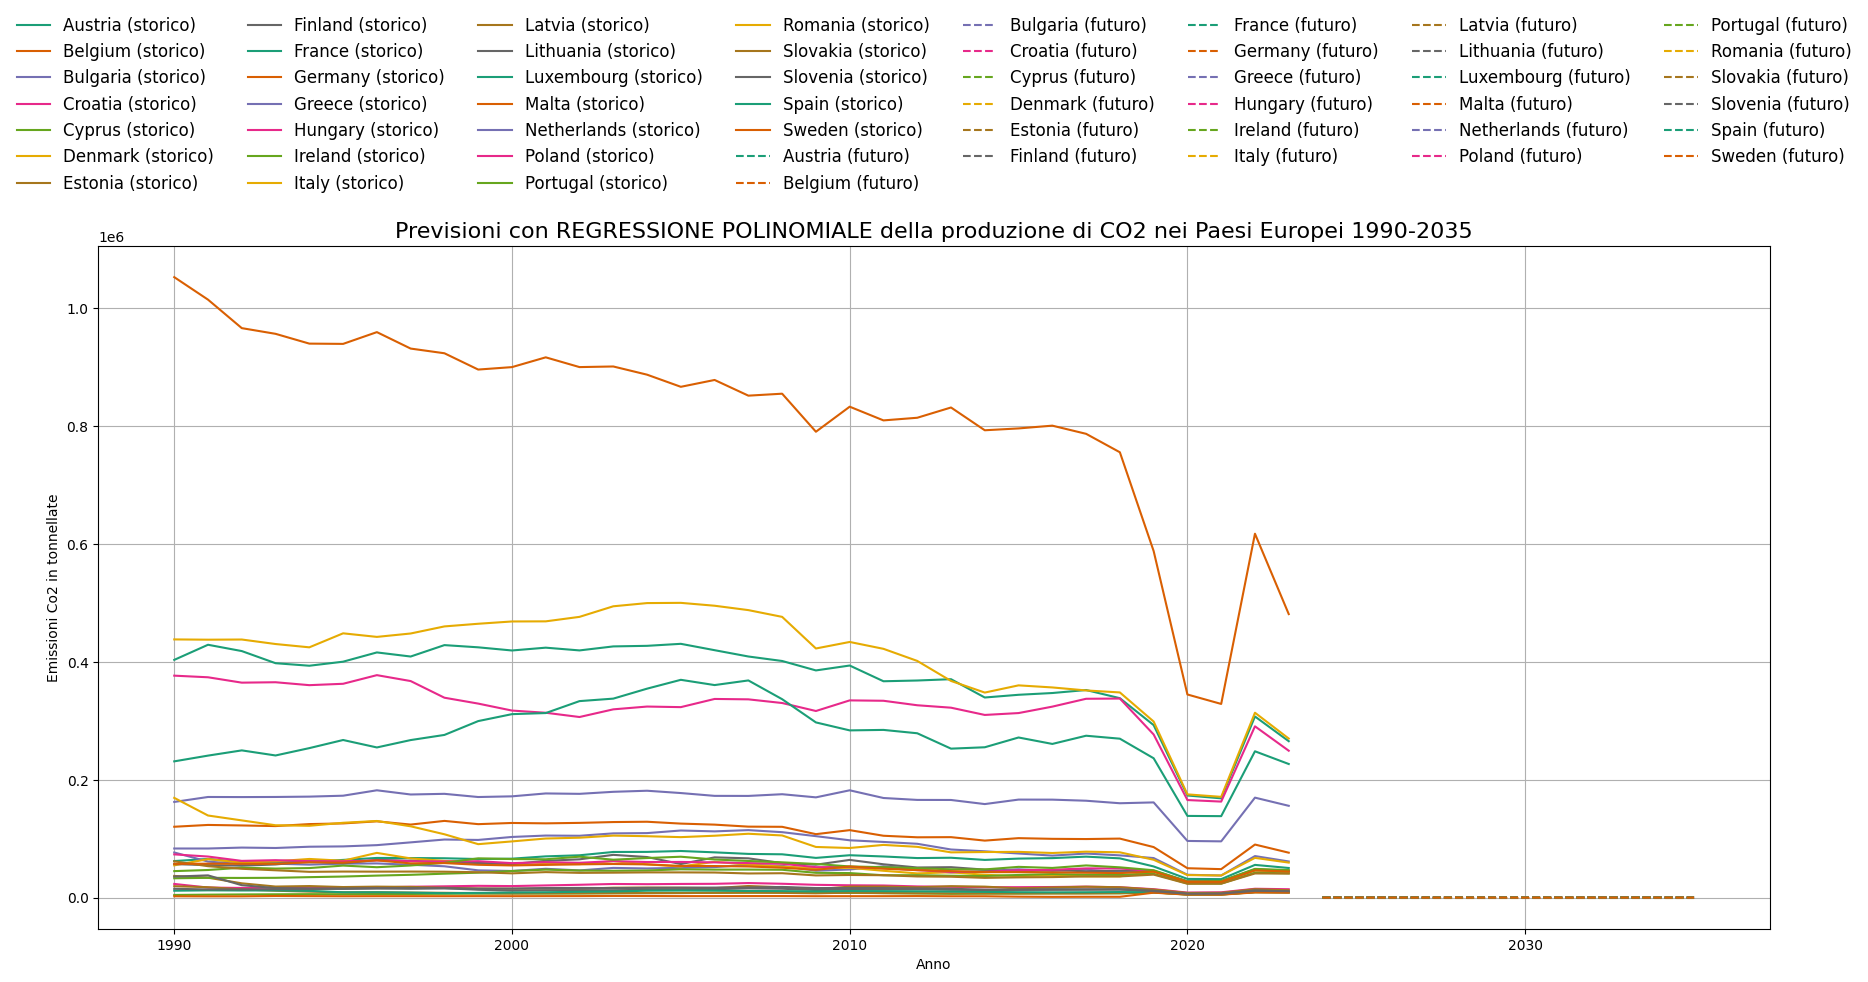

In [43]:
plot_trend(CO2df_eu, co2_predictions_poly, "REGRESSIONE POLINOMIALE", "CO2", "1990-2035","Emissioni Co2 in tonnellate")

In [15]:
# metriche per Country dell'algoritmo predittivo con regressione lineare polinomiale
metrics_poly_df.head()

,Country,RMSE,R2
0,Austria,6424.656257,0.627647
1,Belgium,8731.871800,0.822946
2,Bulgaria,5699.219211,0.572540
3,Croatia,2353.891608,0.598564
4,Cyprus,855.959829,0.476518


In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
import numpy as np
import pandas as pd

def prepare_lstm_data(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

def train_lstm_per_country(df, sequence_length=5, future_steps=12, lstm_units=50, epochs=50, batch_size=16):
    """
    Addestra un modello LSTM per ciascun paese e restituisce:
    - le predizioni future
    - le metriche di valutazione (RMSE, R2)

    Args:
        df (pd.DataFrame): DataFrame con la prima colonna 'Country' e le restanti con anni e valori.
        sequence_length (int): Lunghezza della finestra temporale.
        future_steps (int): Numero di anni futuri da prevedere.
        lstm_units (int): Numero di unità nel layer LSTM.
        epochs (int): Epoche di addestramento.
        batch_size (int): Dimensione del batch per addestramento.

    Returns:
        predictions_df (pd.DataFrame): Predizioni future per ciascun paese.
        metrics_df (pd.DataFrame): RMSE e R2 per ciascun paese.
    """

    predictions_df = pd.DataFrame({'Year': range(2024, 2024 + future_steps)})
    metrics_df = pd.DataFrame(columns=['Country', 'RMSE', 'R2'])

    for country in df['Country'].unique():
        # 1. Estrazione dati
        country_data = df[df['Country'] == country].iloc[:, 1:].values.flatten()

        # 2. Normalizzazione
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(country_data.reshape(-1, 1)).flatten()

        # 3. Sequenze temporali
        X, y = prepare_lstm_data(scaled_data, sequence_length)
        X = X.reshape((X.shape[0], X.shape[1], 1))

        # 4. Costruzione del modello LSTM
        model = Sequential([
            Input(shape=(sequence_length, 1)),
            LSTM(lstm_units, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')

        # 5. Addestramento del modello
        model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)

        # 6. Predizione futura
        future_input = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)
        future_predictions = []

        for _ in range(future_steps):
            pred = model.predict(future_input, verbose=0)[0, 0]
            future_predictions.append(pred)
            future_input = np.append(future_input.flatten()[1:], pred).reshape(1, sequence_length, 1)

        # 7. Inversione scalatura
        future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()
        predictions_df[country] = future_predictions

        # 8. Calcolo delle metriche
        y_pred_scaled = model.predict(X, verbose=0).flatten()
        y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
        y_true = scaler.inverse_transform(y.reshape(-1, 1)).flatten()

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)

        metrics_df.loc[len(metrics_df)] = {'Country': country, 'RMSE': rmse, 'R2': r2}

    return predictions_df, metrics_df


In [17]:
# ADDESTRAMENTO DEL MODELLO LSTM SU CO2
predsCO2, metrics = train_lstm_per_country(CO2df_eu, sequence_length=5, future_steps=12)



In [18]:
print(metrics)
predsCO2.head()


        Country           RMSE        R2
0       Austria    9275.633528  0.324815
1       Belgium   13050.416230  0.641455
2      Bulgaria    5901.988281  0.298342
3       Croatia    2785.411671  0.477016
4        Cyprus     941.198408  0.140063
5       Denmark    6828.563755  0.660707
6       Estonia    2573.405553  0.179873
7       Finland    7822.566178  0.479771
8        France   46330.853500  0.549035
9       Germany  112993.054405  0.516800
10       Greece   13060.455782  0.597521
11      Hungary    5897.677661  0.606618
12      Ireland    5191.972971  0.222124
13        Italy   53190.333515  0.647311
14       Latvia     875.645603  0.137708
15    Lithuania    1993.043500  0.200218
16   Luxembourg    1454.386148  0.141282
17        Malta    1704.220533  0.269293
18  Netherlands   17799.618076  0.224108
19       Poland   39745.817540  0.294129
20     Portugal    7846.064869  0.412637
21      Romania   12228.176986  0.700121
22     Slovakia    4054.564976  0.409837
23     Slovenia 

,Year,Austria,Belgium,Bulgaria,Croatia,Cyprus,Denmark,Estonia,Finland,France,...,Luxembourg,Malta,Netherlands,Poland,Portugal,Romania,Slovakia,Slovenia,Spain,Sweden
0,2024,49832.875000,78229.421875,42307.265625,14214.981445,7651.208008,40822.445312,14142.702148,44927.164062,277903.50000,...,8660.537109,6595.613281,142604.843750,251167.375000,44427.761719,61057.816406,35288.773438,10811.773438,222471.796875,41044.578125
1,2025,49542.250000,77499.429688,42261.710938,14293.748047,7462.849121,40622.550781,14356.574219,44699.101562,275701.37500,...,8611.767578,6247.003906,139750.937500,248271.890625,44263.519531,61160.824219,34950.902344,10782.423828,223095.687500,40595.929688
2,2026,51833.488281,80597.875000,43507.066406,14958.749023,7774.996094,42267.062500,14789.485352,46644.523438,287610.59375,...,8854.951172,6586.614258,145294.890625,257693.343750,46050.269531,63610.082031,36044.046875,11285.398438,231990.312500,42265.097656
3,2027,54537.332031,84368.078125,44870.562500,15615.208984,8162.139160,44047.652344,15201.699219,48849.890625,301948.50000,...,9125.486328,6984.478516,152241.843750,269127.781250,48085.718750,66288.593750,37205.035156,11844.026367,241667.234375,44238.445312
4,2028,54357.203125,83629.789062,44725.066406,15705.928711,7976.985352,43749.000000,15294.062500,48835.964844,300021.46875,...,9076.795898,6510.897949,149457.625000,265742.781250,48030.855469,66354.593750,36756.285156,11866.329102,242048.968750,43827.101562


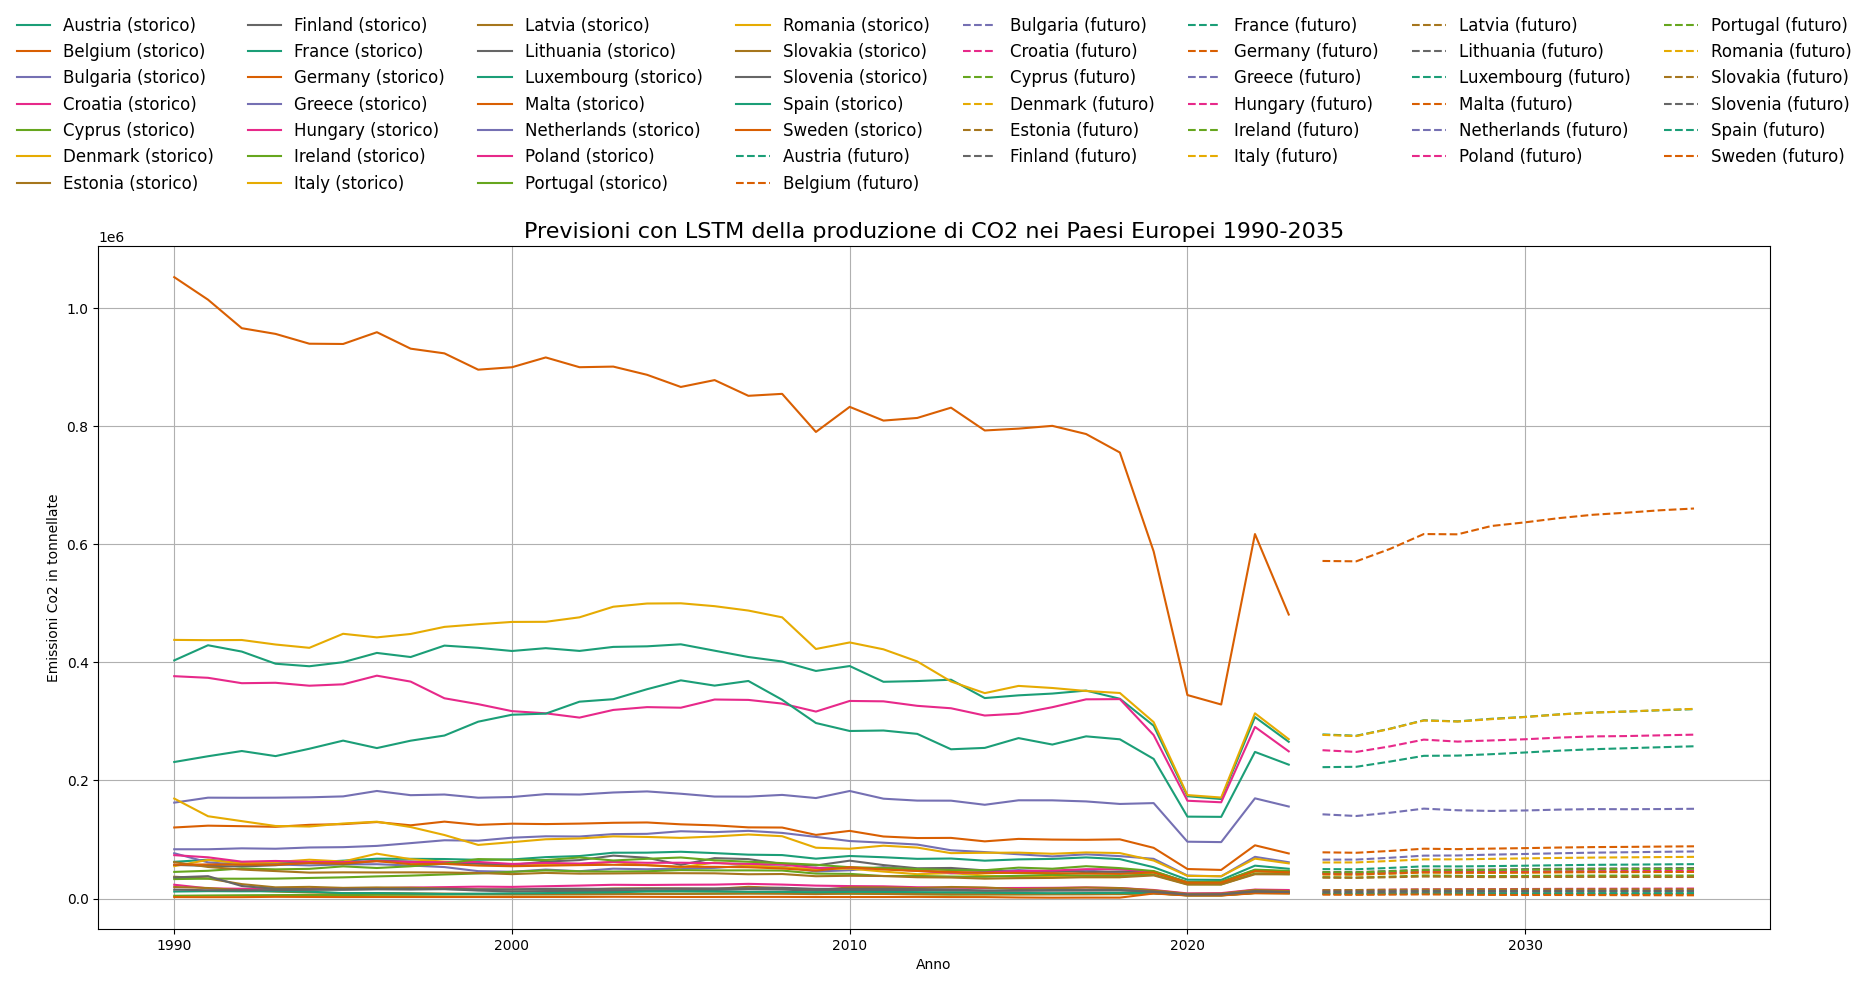

In [44]:
plot_trend(CO2df_eu, predsCO2, "LSTM", "CO2", "1990-2035", "Emissioni Co2 in tonnellate")

In [20]:
# REGRRESSORI ENERGIE RINNOVABILI

#Preparazione

# Estraggo gli anni dalle colonne (escludendo la prima colonna, 'Country')
years = np.array([int(year) for year in Renewable_Electricity_eu.columns[1:]], dtype=int).reshape(-1, 1)

# Definisco gli anni futuri per la previsione (dal 2024 al 2035 incluso)
future_years = np.arange(2024, 2036).reshape(-1, 1)


In [21]:
# REGRESSIONE LINEARE
reg_pred_rinnovabili, reg_df_metrics = linear_regression(Renewable_Electricity_eu, years=years, future_years=future_years)
reg_pred_rinnovabili.head()

,Year,Austria,Belgium,Bulgaria,Croatia,Cyprus,Denmark,Estonia,Finland,France,...,Luxembourg,Malta,Netherlands,Poland,Portugal,Romania,Slovakia,Slovenia,Spain,Sweden
0,2024,73.603158,17.395614,16.365263,62.019649,10.278596,60.593333,7.362982,32.861404,17.882281,...,93.686140,10.909825,13.241404,13.013158,42.728947,40.732807,20.035439,29.811053,36.685439,52.291404
1,2025,74.168684,18.197070,16.697895,62.567772,10.835614,63.004614,7.688123,33.728754,18.199825,...,97.754123,11.208754,13.828912,13.638947,43.215895,41.400614,20.240561,30.040368,37.437193,52.592649
2,2026,74.734211,18.998526,17.030526,63.115895,11.392632,65.415895,8.013263,34.596105,18.517368,...,101.822105,11.507684,14.416421,14.264737,43.702842,42.068421,20.445684,30.269684,38.188947,52.893895
3,2027,75.299737,19.799982,17.363158,63.664018,11.949649,67.827175,8.338404,35.463456,18.834912,...,105.890088,11.806614,15.003930,14.890526,44.189789,42.736228,20.650807,30.499000,38.940702,53.195140
4,2028,75.865263,20.601439,17.695789,64.212140,12.506667,70.238456,8.663544,36.330807,19.152456,...,109.958070,12.105544,15.591439,15.516316,44.676737,43.404035,20.855930,30.728316,39.692456,53.496386


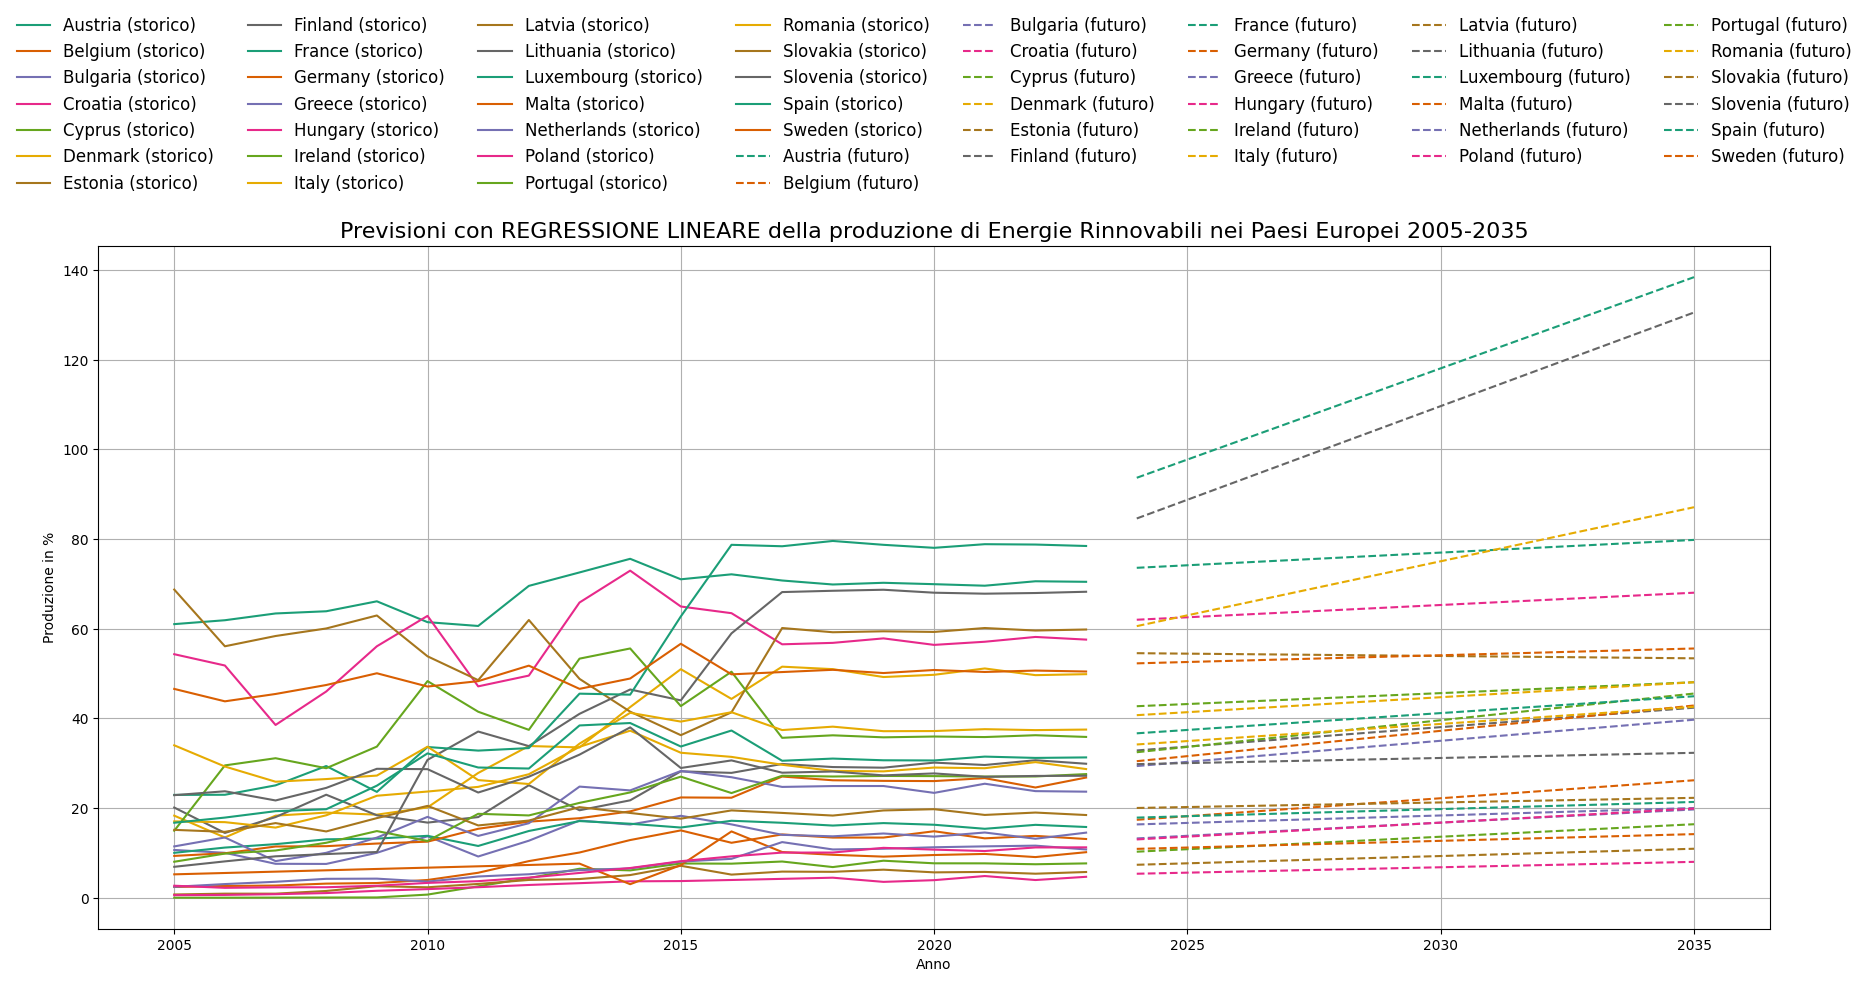

In [47]:
# PLOT PREDIZIONI REGRESSIONE LINEARE ENERGIE RINNOVABILI
plot_trend(Renewable_Electricity_eu, reg_pred_rinnovabili, "REGRESSIONE LINEARE", "Energie Rinnovabili", "2005-2035", "Produzione in %")

In [23]:
# REGRESSIONE POLINOMIALE ENERGIA RINNOVABILE

reg_poly_pred_rinnovabili, reg_poly_df_metrics = regression_polinomial(Renewable_Electricity_eu, degree, years=years, future_years=future_years)
reg_poly_pred_rinnovabili.tail()

,Year,Austria,Belgium,Bulgaria,Croatia,Cyprus,Denmark,Estonia,Finland,France,...,Luxembourg,Malta,Netherlands,Poland,Portugal,Romania,Slovakia,Slovenia,Spain,Sweden
7,2031,61.247668,11.060229,6.299257,37.859651,5.854819,50.609115,2.979156,39.149552,10.630186,...,110.795686,11.215527,16.264966,17.183674,0.0,40.214283,14.762041,11.677011,3.553251,45.327486
8,2032,59.608576,10.247418,4.956966,34.624415,5.287121,49.390235,2.404322,40.046186,9.667337,...,113.327678,11.272997,16.705313,17.781084,0.0,40.180310,14.060508,9.238861,0.000000,44.402700
9,2033,57.843506,9.342363,3.518965,31.172987,4.655153,47.963918,1.778061,40.944493,8.631324,...,115.771899,11.316669,17.137250,18.376872,0.0,40.106235,13.307165,6.648283,0.000000,43.407854
10,2034,55.952458,8.345064,1.985254,27.505366,3.958915,46.330164,1.100373,41.844473,7.522145,...,118.128349,11.346543,17.560778,18.971038,0.0,39.992058,12.502014,3.905279,0.000000,42.342950
11,2035,53.935431,7.255521,0.355834,23.621554,3.198408,44.488971,0.371258,42.746126,6.339801,...,120.397028,11.362619,17.975897,19.563582,0.0,39.837780,11.645054,1.009849,0.000000,41.207987


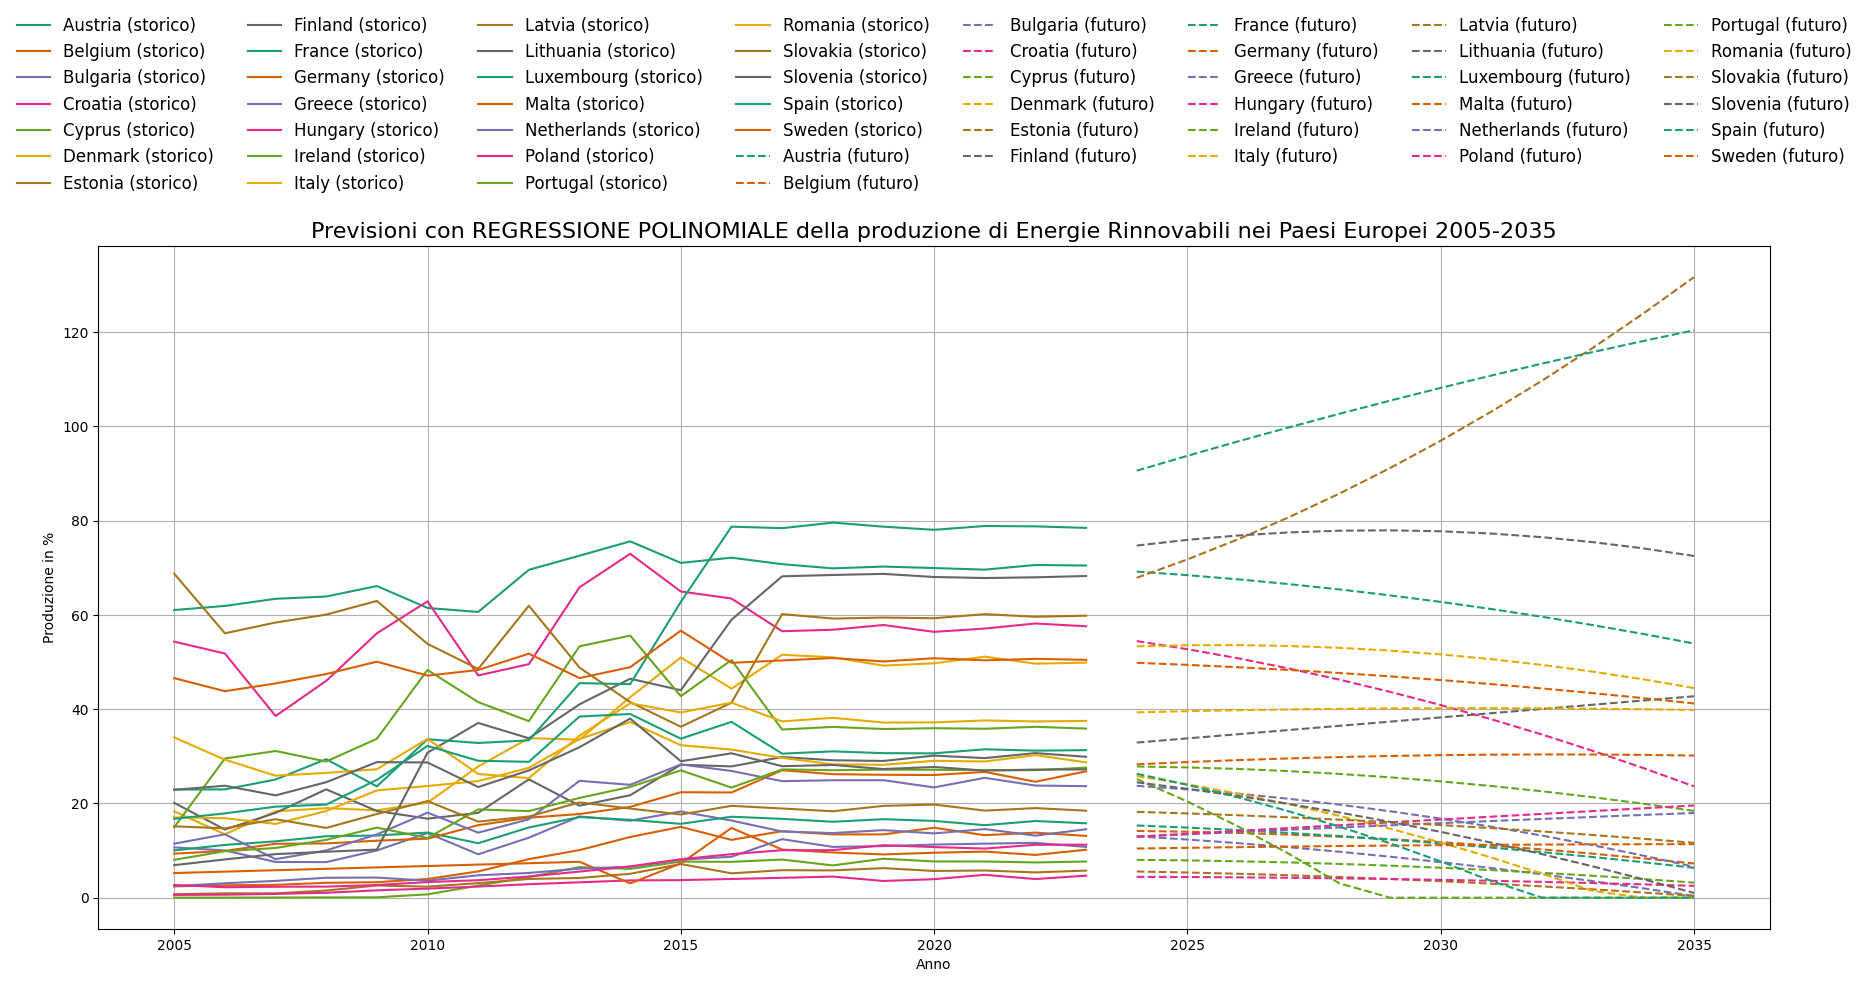

In [48]:
# PLOT PREDIZIONI REGRESSIONE POLINOMIALI ENERGIA RINNOVABILE
plot_trend(Renewable_Electricity_eu, reg_poly_pred_rinnovabili, "REGRESSIONE POLINOMIALE", "Energie Rinnovabili", "2005-2035", "Produzione in %")

In [25]:
# ADDESTRAMENTO DEL MODELLO LSTM SULLE ENERGIE RINNOVABILI
lstm_preds_energy, energy_metrics_lstm = train_lstm_per_country(Renewable_Electricity_eu, sequence_length=5, future_steps=12)

In [26]:
print(energy_metrics_lstm)
lstm_preds_energy.head()

        Country       RMSE        R2
0       Austria   3.836568 -0.011681
1       Belgium   3.762115 -0.273579
2      Bulgaria   2.604562 -0.490707
3       Croatia   8.510133 -0.788172
4        Cyprus   2.153372  0.029725
5       Denmark   8.127505  0.324632
6       Estonia   1.940240 -1.441371
7       Finland   3.345857  0.509699
8        France   1.383978  0.078211
9       Germany   2.745952  0.661997
10       Greece   4.097988 -0.096866
11      Hungary   0.443103  0.701168
12      Ireland   2.527077  0.676817
13        Italy   3.812706 -0.315533
14       Latvia   8.707302 -0.089710
15    Lithuania  18.846995 -0.666797
16   Luxembourg  14.980534  0.400706
17        Malta   2.400490  0.090022
18  Netherlands   2.140806  0.442794
19       Poland   1.319021  0.785962
20     Portugal   8.598991 -0.480398
21      Romania   4.407392  0.092561
22     Slovakia   1.403563 -0.522938
23     Slovenia   3.574169 -0.257035
24        Spain   5.371660 -1.802286
25       Sweden   2.444954 -0.143981


,Year,Austria,Belgium,Bulgaria,Croatia,Cyprus,Denmark,Estonia,Finland,France,...,Luxembourg,Malta,Netherlands,Poland,Portugal,Romania,Slovakia,Slovenia,Spain,Sweden
0,2024,71.877983,10.701150,15.366335,53.557674,6.379509,45.188980,3.952357,33.238052,16.957159,...,71.715576,9.124157,10.121599,11.126863,37.245720,39.702316,19.619047,26.794958,29.665842,51.525112
1,2025,72.085861,10.466171,15.418611,53.279449,6.126447,44.845718,3.747566,34.026043,16.976450,...,70.868233,9.145502,10.016699,11.089812,37.457260,40.035229,19.620171,26.767273,29.573492,51.644108
2,2026,72.418617,10.006724,15.708908,53.121819,5.939690,44.390095,3.581614,34.726158,17.083611,...,69.916641,9.127677,9.833892,11.140807,37.661961,40.433613,19.565256,26.715582,29.446062,51.695499
3,2027,72.914223,9.672850,15.798812,52.874676,5.728940,43.502487,3.399813,35.834110,17.424438,...,68.505325,9.073732,9.572794,11.307621,37.918274,40.876629,19.768520,26.701756,29.165270,51.810986
4,2028,73.314392,9.229493,16.313519,52.468273,5.510115,42.703732,3.242442,36.994499,17.649836,...,66.761879,9.108392,9.236693,11.314667,38.152840,41.509617,19.914185,26.676451,28.884663,51.911835


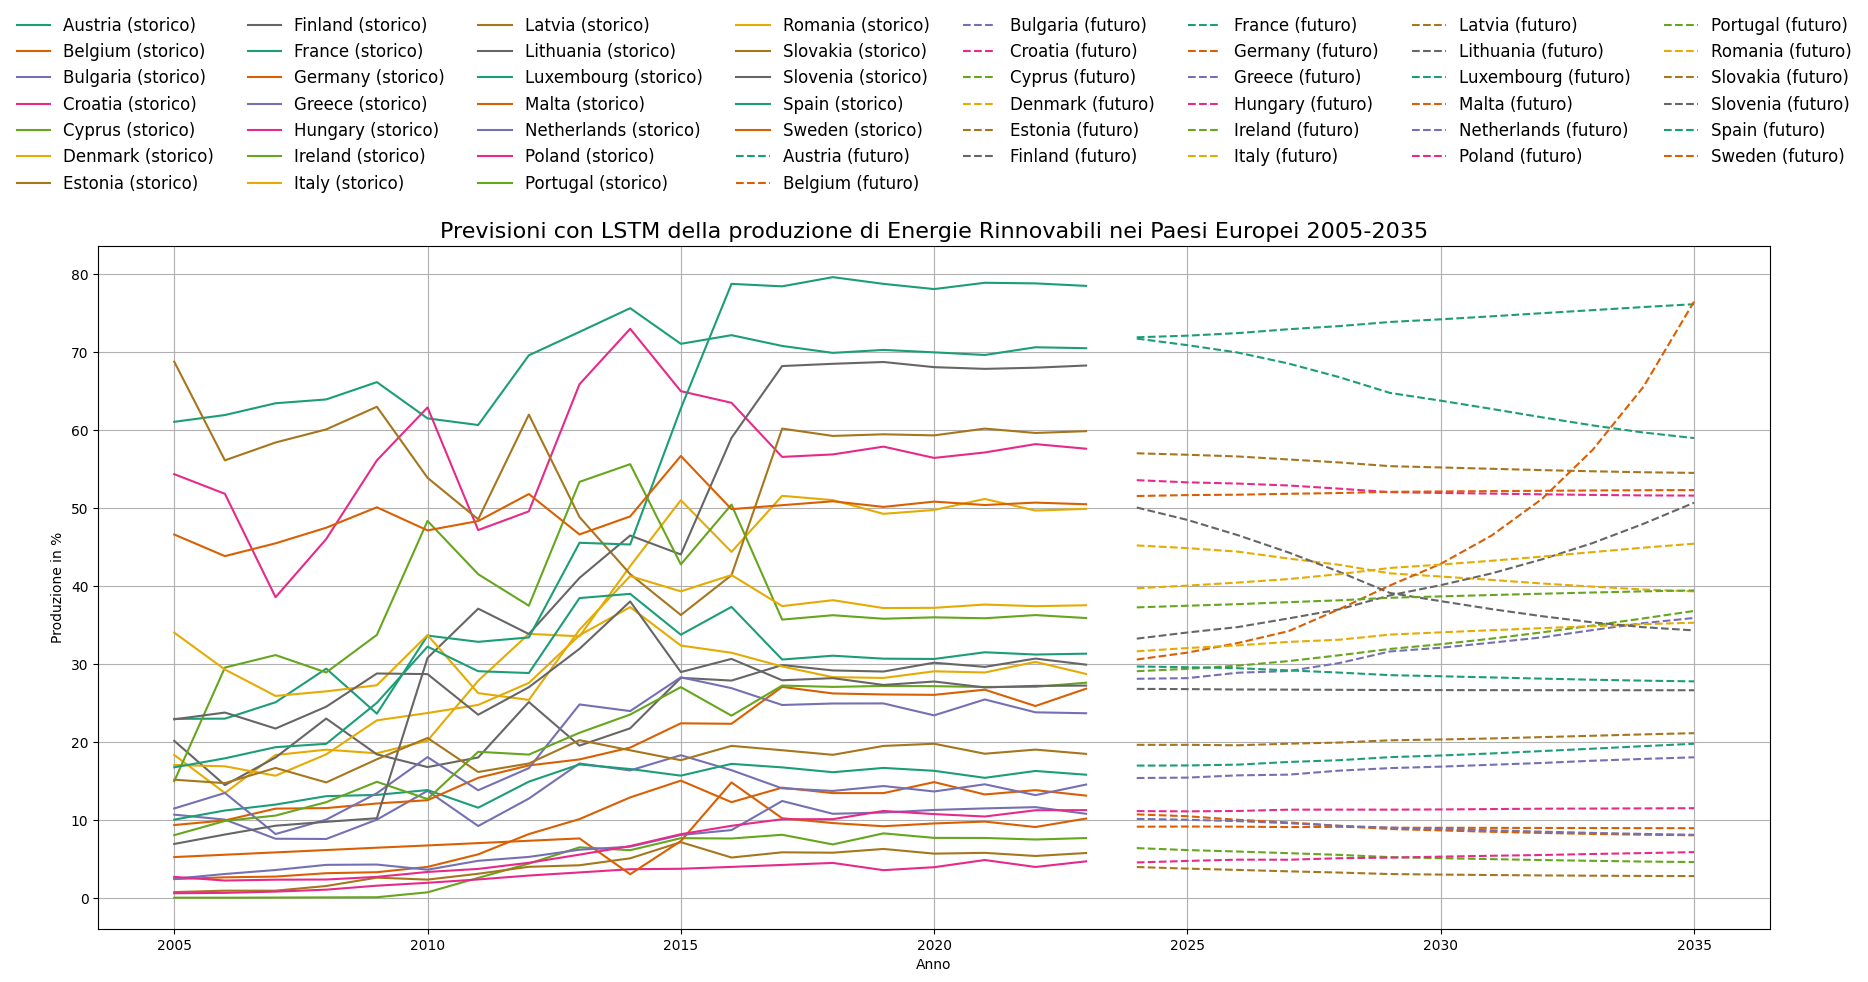

In [49]:
# PLT PREDIZIONI LSTM ENERGIA RINNOVABILE
plot_trend(Renewable_Electricity_eu, lstm_preds_energy, "LSTM", "Energie Rinnovabili", "2005-2035","Produzione in %")

In [28]:
"""
def visualize_top(df, column='Renewable_Electricity', titlelabel="label", top_n=10, xlabel="xlabel", palette='crest'):
    """
    Visualizza la classifica dei paesi europei con la maggiore produzione di energia rinnovabile.

    Args:
        df (pd.DataFrame): DataFrame contenente i dati con almeno le colonne 'Country' e la colonna indicata.
        column (str): Nome della colonna con i dati di energia rinnovabile.
        top_n (int): Numero di paesi da visualizzare (default: 10).
    """
    # Copia e conversione in milioni
    df_milioni = df.copy()
    #df_milioni[column] = df_milioni[column] / 1_000_000

    # Ordinamento e selezione top
    top_df = df_milioni.sort_values(by=column, ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(18, 8))
    sns.barplot(
        x=column,
        y='Country',
        data=top_df,
        palette=f'{palette}',
        dodge=False
    )

    plt.title(f'{titlelabel}', fontsize=14)
    plt.xlabel(f'{xlabel}')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()


"""

In [29]:
# preparo il dataframe per i top paesi per produzione di Co2 nel 2035
reg_pred_co2 = regression_predictions.copy()
reg_pred_co2.tail()

,Year,Austria,Belgium,Bulgaria,Croatia,Cyprus,Denmark,Estonia,Finland,France,...,Luxembourg,Malta,Netherlands,Poland,Portugal,Romania,Slovakia,Slovenia,Spain,Sweden
7,2031,55317.984770,68780.388289,33362.608225,15330.463112,8689.269561,26521.665989,9628.786781,38760.903348,250148.408235,...,8218.623476,5466.008118,143205.969037,236935.599786,44850.120856,33094.256321,27153.056364,11422.062011,242020.496246,32455.988139
8,2032,54924.323992,67080.768327,32695.521730,15188.395688,8754.038979,25502.464889,9293.393624,38099.002764,245100.924454,...,8144.847051,5559.707513,142262.653812,233490.774255,44480.636173,30523.871693,26598.979312,11288.848707,240633.252539,31715.096490
9,2033,54530.663215,65381.148365,32028.435235,15046.328264,8818.808397,24483.263789,8958.000468,37437.102180,240053.440672,...,8071.070626,5653.406908,141319.338587,230045.948724,44111.151490,27953.487065,26044.902261,11155.635404,239246.008833,30974.204842
10,2034,54137.002437,63681.528403,31361.348739,14904.260840,8883.577815,23464.062689,8622.607311,36775.201597,235005.956891,...,7997.294202,5747.106303,140376.023361,226601.123193,43741.666807,25383.102437,25490.825210,11022.422101,237858.765126,30233.313193
11,2035,53743.341659,61981.908442,30694.262244,14762.193416,8948.347233,22444.861589,8287.214154,36113.301013,229958.473109,...,7923.517777,5840.805697,139432.708136,223156.297662,43372.182124,22812.717809,24936.748159,10889.208798,236471.521419,29492.421545


In [30]:
# Funzione per creare un dataframe per il plot dei grafici

def rank_renewables(df, year, top_n=None, val='value'):
    """
    Ritorna i paesi ordinati per produzione di energia rinnovabile in un dato anno.

    Parametri:
        df (pd.DataFrame): DataFrame con colonna 'Year' e colonne per ciascun paese.
        year (int): anno su cui filtrare.
        top_n (int, opzionale): se specificato, ritorna solo i primi top_n paesi.

    Ritorna:
        pd.DataFrame: DataFrame con colonne ['Country', 'Renewable'] ordinate decrescente.
    """
    # Filtra l'anno
    df_year = df[df['Year'] == year]
    if df_year.empty:
        raise ValueError(f"Nessun dato per l’anno {year}")
    # Rimuove colonna Year, trasforma in long format
    df_long = df_year.drop(columns=['Year']).T.reset_index()
    df_long.columns = ['Country', f'{val}']
    df_long[f'{val}'] = pd.to_numeric(df_long[f'{val}'], errors='coerce')
    df_sorted = df_long.sort_values(f'{val}', ascending=False)
    if top_n:
        df_sorted = df_sorted.head(top_n)
    return df_sorted




In [31]:
# Dataframe top country 2035 per CO2:
top_country_co2_2035_pred = rank_renewables(reg_pred_co2, 2035, top_n=27, val='co2')
top_country_co2_2035_pred.head()


,Country,co2
9,Germany,416237.090889
24,Spain,236471.521419
13,Italy,232892.971814
8,France,229958.473109
19,Poland,223156.297662


In [32]:
def visualize_top(df, column=None, titlelabel="label", top_n=27, xlabel="xlabel", palette='crest'):
    """
    Args:

        top_n (int): Numero di paesi da visualizzare (default: 10).
    """
    # Copia e conversione in milioni
    df_milioni = df.copy()

    # Ordinamento e selezione top
    top_df = df_milioni.sort_values(by=column, ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(18, 8))
    sns.barplot(
        x=column,
        y='Country',
        data=top_df,
        palette=f'{palette}',
        dodge=False
    )

    plt.title(f'{titlelabel}', fontsize=14)
    plt.xlabel(f'{xlabel}')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()




/tmp/ipython-input-32-3003053386.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


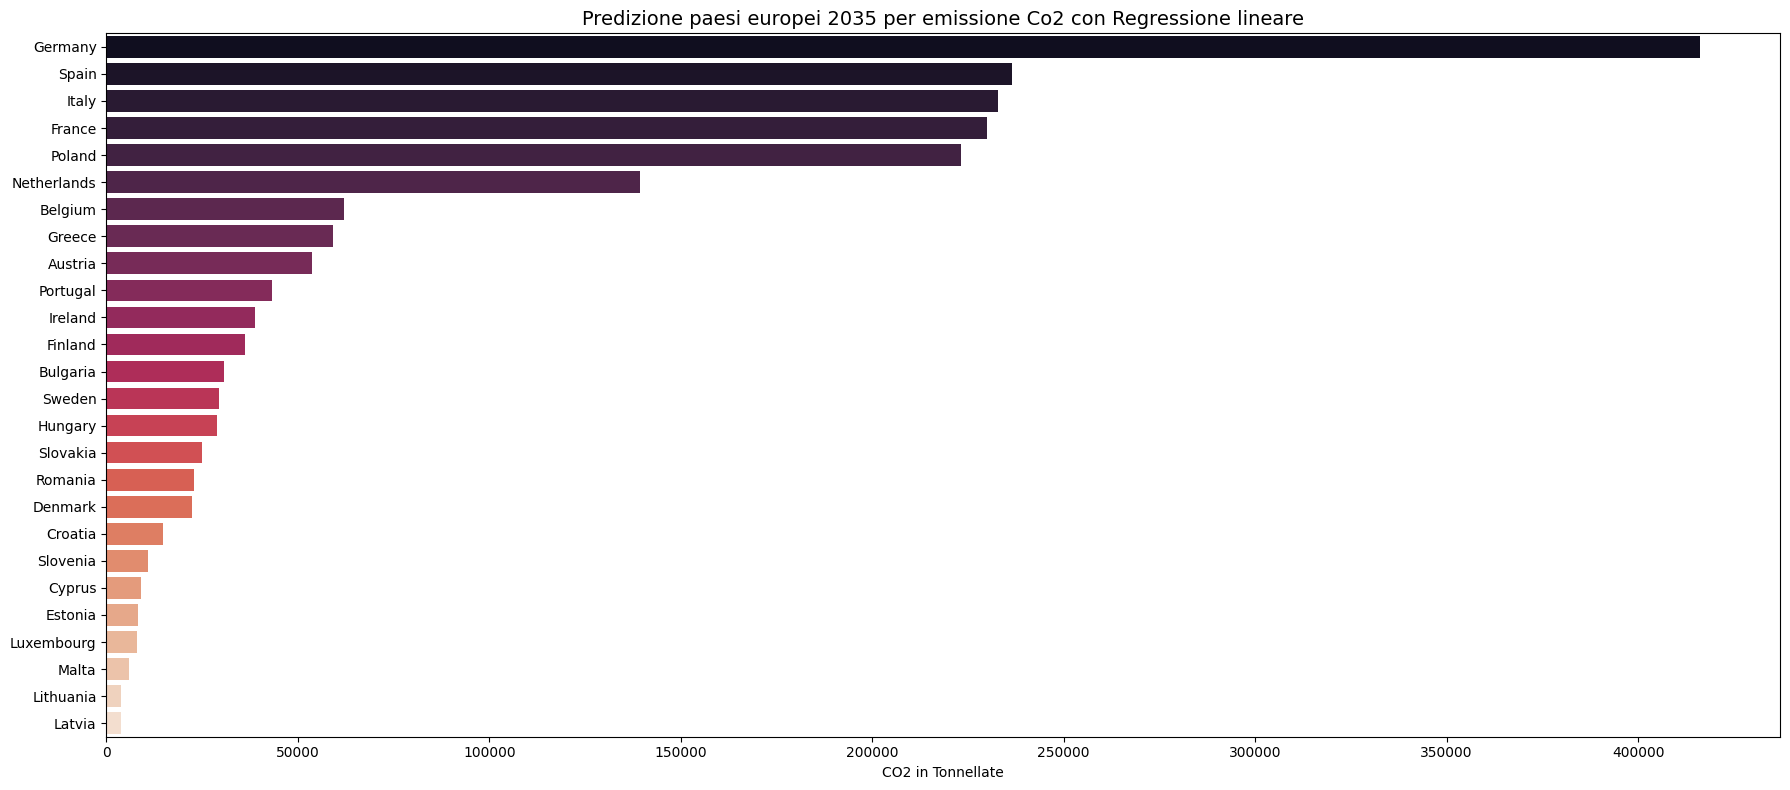

In [40]:
visualize_top(top_country_co2_2035_pred, column='co2', titlelabel='Predizione paesi europei 2035 per emissione Co2 con Regressione lineare', top_n=27, xlabel='CO2 in Tonnellate', palette='rocket')


In [34]:
# preparo il dataframe per i top paesi per produzione di energia rinnovabile nel 2035
reg_pred_rinnovabili = reg_pred_rinnovabili.copy()
reg_pred_rinnovabili.tail()

,Year,Austria,Belgium,Bulgaria,Croatia,Cyprus,Denmark,Estonia,Finland,France,...,Luxembourg,Malta,Netherlands,Poland,Portugal,Romania,Slovakia,Slovenia,Spain,Sweden
7,2031,77.561842,23.005807,18.693684,65.856509,14.177719,77.472298,9.638965,38.932860,20.105088,...,122.162018,13.002333,17.353965,17.393684,46.137579,45.407456,21.471298,31.416263,41.947719,54.400123
8,2032,78.127368,23.807263,19.026316,66.404632,14.734737,79.883579,9.964105,39.800211,20.422632,...,126.230000,13.301263,17.941474,18.019474,46.624526,46.075263,21.676421,31.645579,42.699474,54.701368
9,2033,78.692895,24.608719,19.358947,66.952754,15.291754,82.294860,10.289246,40.667561,20.740175,...,130.297982,13.600193,18.528982,18.645263,47.111474,46.743070,21.881544,31.874895,43.451228,55.002614
10,2034,79.258421,25.410175,19.691579,67.500877,15.848772,84.706140,10.614386,41.534912,21.057719,...,134.365965,13.899123,19.116491,19.271053,47.598421,47.410877,22.086667,32.104211,44.202982,55.303860
11,2035,79.823947,26.211632,20.024211,68.049000,16.405789,87.117421,10.939526,42.402263,21.375263,...,138.433947,14.198053,19.704000,19.896842,48.085368,48.078684,22.291789,32.333526,44.954737,55.605105


In [38]:
# Dataframe top country 2035 per produzione energetica:
top_country_energie_rinnovabili_2035_pred = rank_renewables(reg_pred_rinnovabili, 2035, top_n=27)
top_country_energie_rinnovabili_2035_pred

,Country,value
16,Luxembourg,138.433947
15,Lithuania,130.553789
5,Denmark,87.117421
0,Austria,79.823947
3,Croatia,68.049000
25,Sweden,55.605105
14,Latvia,53.414579
20,Portugal,48.085368
21,Romania,48.078684
12,Ireland,45.558895


/tmp/ipython-input-32-3003053386.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


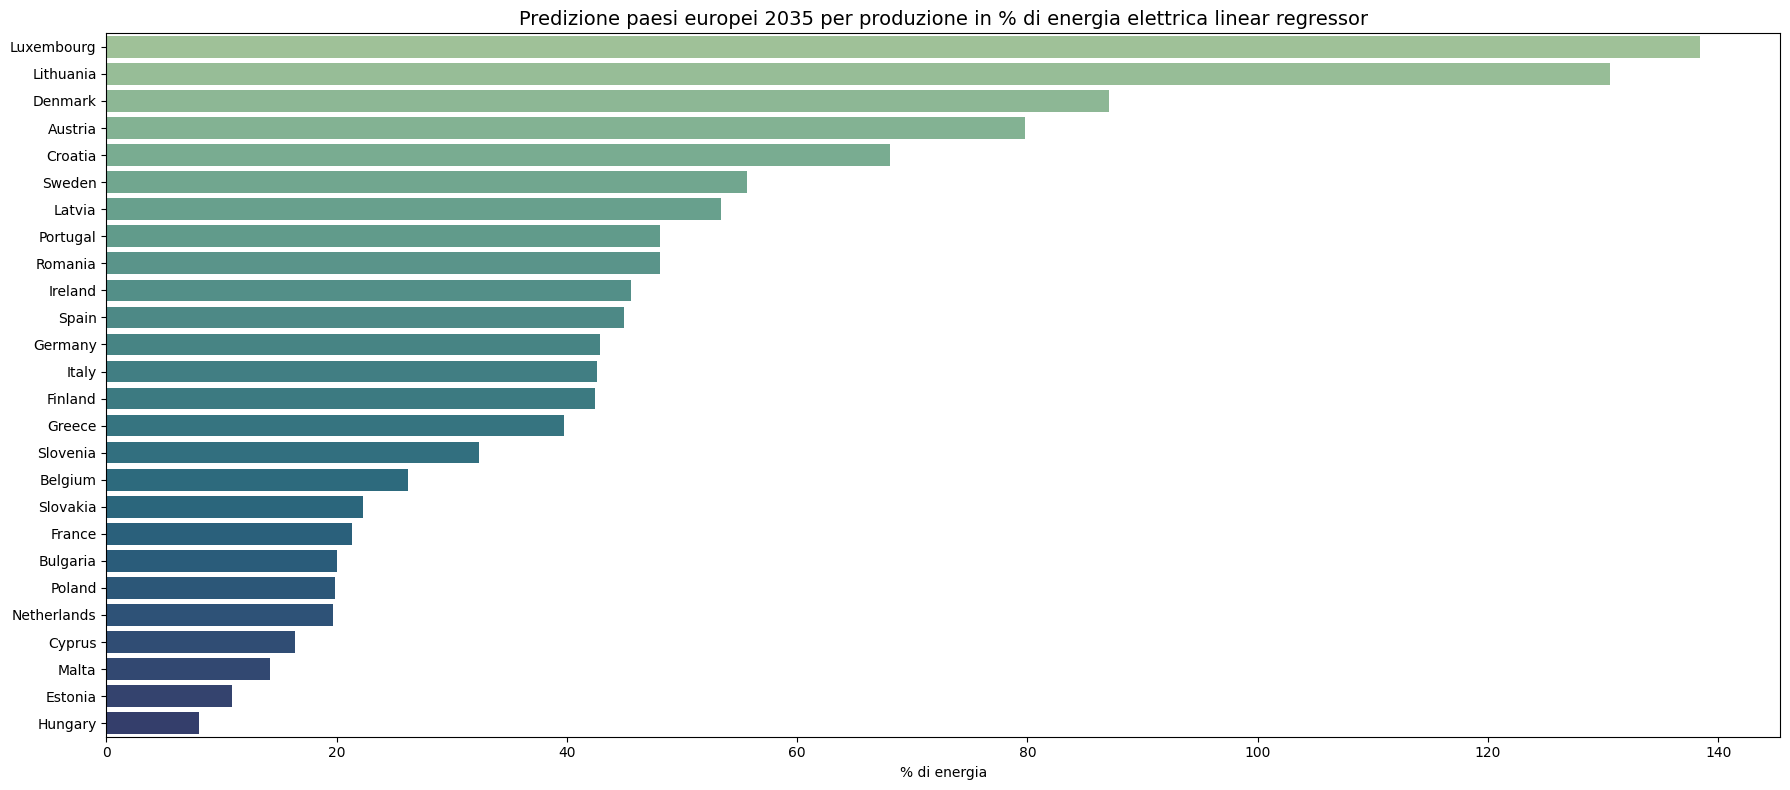

In [41]:
visualize_top(top_country_energie_rinnovabili_2035_pred, column='value', titlelabel='Predizione paesi europei 2035 per produzione in % di energia elettrica linear regressor', top_n=27, xlabel='% di energia', palette='crest')
